## Training and visualizing the Diffusion model

This notebook trains a diffusion model using visuo-tactile information from a soft-bubble sensor. The implementation is from Hugginface and can be found at [link](https://huggingface.co/blog/annotated-diffusion).

In the directory *model* you can find all the different files with the code use in this notebook. I'll try to explain each step taken as we move forward.

Fisrt, lets setup the enviroment so that we can edit .py files, and re-import them into the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

We now import some usefull libraries:

In [2]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F


import numpy as np

### Parts of a Diffusion model:
- Initial distribution: q(x_0) from real data.
- Target distribution: Pure gaussian noise. N(0,sigma*I)
- Beta/variance schedule.
- U-net block.
- Attention
- 
-

Let's define first the beta schedule for a toy example. The example uses a linear scheduler (not recommended) and a timestep of 300.

In [3]:
from model.diffusion.beta_schedule import linear_beta_schedule


timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

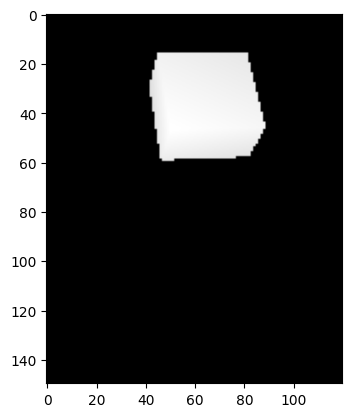

In [4]:
dataset_dir = "./data/datasets/toy_dataset/serious_toy1/"
img_dir = "scene_test/depth_gt/depth_data/depth_000111.npy"

image = np.load(dataset_dir + img_dir)

plt.imshow(image, cmap='gray_r')
plt.show()

In [5]:
from torchvision.transforms import Compose, ToTensor, Lambda, Resize


bg_value = np.max(image)
img_shape = image.shape[:2]
img_size = np.max(img_shape) - 2

transform = Compose([
    ToTensor(), # turn into torch Tensor of shape CHW
    Lambda(lambda t: (t / bg_value * 2) - 1),
    Resize((img_size, img_size))
])

reverse_transform = Compose([
    Resize(img_shape),
    Lambda(lambda t: (t + 1) * bg_value / 2),
    Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    Lambda(lambda t: t.detach().cpu().numpy())
])

x_start = transform(image).unsqueeze(0)
x_reversed = reverse_transform(x_start.squeeze(0))

print(x_start.shape)
print(x_reversed.shape)

torch.Size([1, 1, 148, 148])
(150, 120, 1)


In [6]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze(0))

  return noisy_image

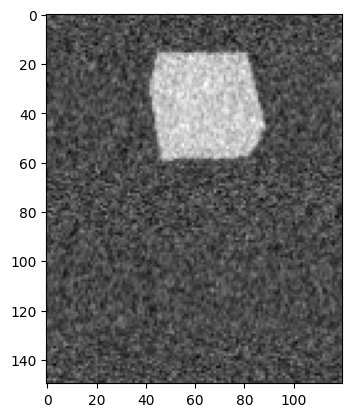

In [7]:
t = torch.tensor([40])

noise_img = get_noisy_image(x_start, t)

plt.imshow(noise_img, cmap='gray_r')
plt.show()

In [8]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(img, cmap='gray_r')
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [9]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [10]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [16]:
from data.dataloader.dataloader import BubbleDataset


dataset_dir = "./data/datasets/toy_dataset/serious_toy1/processed_data/serious_toy1/"

dataset = BubbleDataset(dataset_dir, transform)
print(f"Dataset len: {dataset.__len__()} image pairs")

Dataset len: 10000 image pairs


In [12]:

from torch.utils.data import DataLoader


channels = 1
batch_size = 2

# You can define parameters such as batch size, whether to shuffle the data, etc.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
batch = next(iter(dataloader))
print(type(batch), " Len: ", len(batch))

<class 'dict'>  Len:  11


In [14]:
@torch.no_grad
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad
def sample(model, img_size, batch_size=16, channels=1):
    return p_sample_loop(model, shape=(batch_size, channels, img_size, img_size))

In [15]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 500

In [23]:
from torch.optim import Adam
from model.diffusion.u_net import Unet


device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

model = Unet(
    dim=img_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

device:  cuda


In [17]:
from torchvision.utils import save_image

epochs = 6

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["depth_gt"].shape[0]
      batch = batch["depth_gt"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.5449213981628418
Loss: 6.640350341796875
Loss: 1.641344428062439
Loss: 3.6933679580688477
Loss: 0.8843176364898682
Loss: 0.4192826449871063


In [18]:
# sample 64 images
samples = sample(model, img_size=img_size, batch_size=2, channels=channels)

# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(img_size, img_size, channels), cmap="gray")

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

IndexError: index 5 is out of bounds for axis 0 with size 2

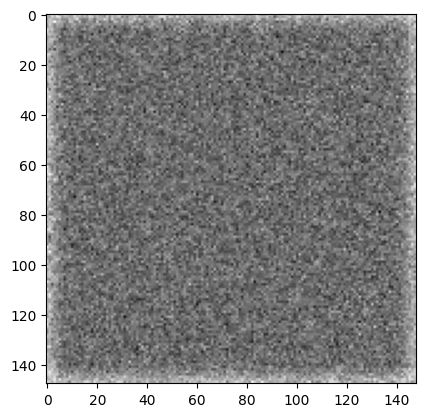

In [20]:
# show a random one
random_index = 0
plt.imshow(samples[-1][random_index].reshape(img_size, img_size, channels), cmap="gray")